In [4]:
import matplotlib.pyplot as plt
import vaex
import os
import numpy as np
import pandas as pd
from helpers import *

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from helpers import *
import pandas as pd
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  # default='warn'
## Parallel function to compute response function
from multiprocessing import Pool
import multiprocessing
from scipy.stats import wasserstein_distance
from sklearn.neighbors import KernelDensity
from fastdtw import fastdtw
from scipy.stats import ttest_ind, ranksums
import time
import seaborn as sns

### 1) Data Labelling
Assumption : a flash crash is defined as a price drop of more than 5% in a 30 minute window


In [2]:
# Data loading
current_dir  = os.getcwd()
loading_dir = os.path.join(current_dir,"data","clean", "flash_crash")
ticker_list = os.listdir(loading_dir)
if '.DS_Store' in ticker_list : ticker_list.remove('.DS_Store')
ticker_name =   ticker_list[1]
print("Ticker name: ", ticker_name)

plots_dir = os.path.join(current_dir,"plots","flash_crash",ticker_name)
file_dir = os.path.join(loading_dir,ticker_name)
file_name = os.listdir(file_dir)[0]
df = vaex.open(os.path.join(file_dir,file_name))

# Data cleaning 
df = df[ (df.index>= '2010-01-01') & (df.index<= '2010-12-31') ]

df = df.dropnan(column_names=["trade_price"])
df = df.to_pandas_df()
df.loc[:, ['bid-price', 'bid-volume','ask-price','ask-volume', ]] = df[['bid-price','bid-volume','ask-price','ask-volume']].ffill().fillna(method='bfill')
df["mid_price"] = (df["bid-price"] + df["ask-price"])/2
ny_index = pd.DatetimeIndex(df['index']) 
ny_index = ny_index.tz_localize('UTC').tz_convert('America/New_York')
df['ny_index'] = ny_index 
df.set_index('ny_index',drop=True,inplace=True)


# Data Labelling
## Label as flash crash where the drop and recovery exceed the thresholds within the window
WINDOW = '1800s' # 30 minutes
PRICE_DROP_THRESHOLD = 0.05  # 5% price drop

def max_pct_change(series):
    if len(series) < 2:
        return 0
    return ((series.max() - series) / series).max()

def min_pct_change(series):
    if len(series) < 2:
        return 0
    return ((series.min() - series) / series).min()

# Calculate the rolling max and min percentage change for the 'mid_price' column
df['max_price_pct_change'] = df['mid_price'].rolling(WINDOW).apply(max_pct_change, raw=True)
df['min_price_pct_change'] = df['mid_price'].rolling(WINDOW).apply(min_pct_change, raw=True)
df['flash_crash'] = ((df['min_price_pct_change'] <= -PRICE_DROP_THRESHOLD) & (df['max_price_pct_change'] >= PRICE_DROP_THRESHOLD) ).astype(int)

print(df.flash_crash.value_counts(normalize=True))
df[['max_price_pct_change','min_price_pct_change']].describe()
print("Without sampling, df is of length : ",len(df))
df_original = df.copy()

Ticker name:  AAPL.OQ-2010
flash_crash
0    0.992558
1    0.007442
Name: proportion, dtype: float64
Without sampling, df is of length :  5608234


### Flash Crash days inspection:

In [3]:
## Days with flash crash
df_daily_crash = df.resample('1D').agg({'flash_crash': 'sum'})
df_daily_crash[df_daily_crash['flash_crash'] > 0]    

,flash_crash
ny_index,
2010-05-06 00:00:00-04:00,11891
2010-05-07 00:00:00-04:00,9102
2010-09-28 00:00:00-04:00,8669
2010-10-19 00:00:00-04:00,12076


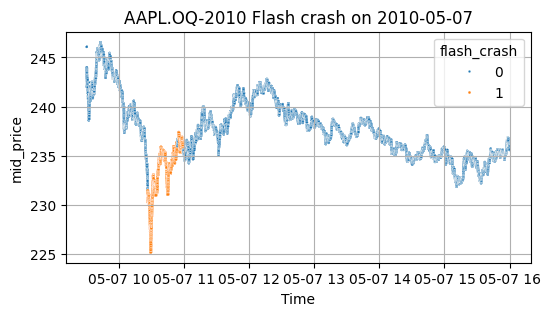

In [7]:
df  = df_original.copy()
df_crash1 = df[(df.index >= '2010-05-07')&(df.index <= '2010-05-08')]
plt.figure(figsize=(6,3))
sns.scatterplot(data=df_crash1, x=df_crash1.index, y='mid_price', hue='flash_crash',size='flash_crash',sizes=(4, 3),)
plt.title(ticker_name+ " Flash crash on 2010-05-07")
plt.xlabel('Time')
plt.grid()

#### Discussion : 
As expected, we notice that the occurences of flash crashes are very rare. In fact, with our definition of a flash crash (i.e: drop >5% within 30 minute interval), we notice only 3 months where it happened and more precisely in 4 days. After careful inspection, the first one is the famous big flash crash, the second one is on the day just after and the last two are actually just price redress at market opening.

In [67]:
# Percentage of flash crash labels in flash crash period
df_original[(df_original.index >= '2010-05-06') & (df_original.index <= '2010-05-08')].flash_crash.value_counts(normalize=True)

flash_crash
0    0.799068
1    0.200932
Name: proportion, dtype: float64

In [8]:
## Group trades into minutes by taking sum of trade volume, mean price.. and label as flash crash if the number of trades exceed the threshold within the window
df_resampled = df.copy()
df_resampled =  df_resampled[ (df_resampled.index >= '2010-05-06') & (df_resampled.index <= '2010-05-07')]
df_resampled = df_resampled.resample('1s').agg({'trade_price': 'mean', 'trade_volume': 'sum', 'ask-price': 'mean', 'bid-price': 'mean', 'ask-volume': 'sum', 'bid-volume': 'sum', 'mid_price': 'mean', 'max_price_pct_change': 'max', 'min_price_pct_change': 'min', 'flash_crash': 'max'})
df_resampled.dropna(inplace=True)
print(df_resampled.flash_crash.value_counts(normalize=True))
print(df_resampled[['max_price_pct_change','min_price_pct_change']].describe())
df = df_resampled.copy()

flash_crash
0.0    0.832337
1.0    0.167663
Name: proportion, dtype: float64
       max_price_pct_change  min_price_pct_change
count          12883.000000          12883.000000
mean               0.048328             -0.041524
std                0.077736              0.061754
min                0.004639             -0.202884
25%                0.008907             -0.038421
50%                0.012529             -0.012374
75%                0.039956             -0.008829
max                0.254523             -0.004618


### Training 
Note: Training should be done on a rolling calibration.
We cannot just perform a logistic regresssion because the flash crash actually only happens a few times so with a rolling callibration, we will mostly have one class (0: non flash crash). We can either try to label our data with a probability of crash but this needs very stong assumptions about price volatility and other metrics. Or the method we will be implementing is using the market response function. First we need a regression on a the response function, then a classification using a simple model (exceeding a magnitude threshold in values/spread)

Note: We need to use F1 score since the data is very imbalanced.

### Model 1) 10% Significance One sided test

In [ ]:
def compute_deviation(y_pred, y_true , weight_ttest=0.5,  weight_stability=0.5 ):
    # Response magnitude
    _, p_value_t = ttest_ind(y_pred, y_true,alternative='less',equal_var=False)
    _, p_value_u = ranksums(y_pred, y_true,alternative='less')

    # Calculate the coefficient of variation (CV)
    #cv_true = abs(np.std(y_true) / np.mean(y_true))
    #cv_pred = abs(np.std(y_pred) / np.mean(y_pred))
    #if cv_true>cv_pred:
     #   deviation_stability = ((cv_true-cv_pred)/ cv_true)
    #else:
     #   deviation_stability = ((cv_pred-cv_true)/ cv_pred)

    #overall_deviation = (2-p_value_t-p_value_u)/2 * weight_ttest + deviation_stability*weight_stability
    overall_deviation = (2-p_value_t-p_value_u)/2 
    return overall_deviation



# Parameters
k = 1000  # Window size
tau_max = k # should be equal to k
threshold = 0.9  # Threshold for deviation
# Initialize model
df = df[ (df.index>= '2010-05-06 12:30') & (df.index<= '2010-05-07') ]
model = LinearRegression()

metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 10
nb_plots = 10
# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['flash_crash'],inplace=True)
    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    deviation = compute_deviation(y_pred, y_train)
    total_deviation_list.append(deviation)
    if not df[i-k:i].flash_crash.sum():
        deviation_list.append(deviation)

    predicted_flash_crash = False
    if False:
        window_deviation = np.mean(deviation_list[-deviation_nb_threshold:])
        print("Deviation mean",window_deviation)
        predicted_flash_crash = abs(deviation)  > 2* abs(window_deviation)
    else :
        predicted_flash_crash = (deviation >= threshold )

    metrics = update_metrics(metrics,predicted_flash_crash, df.iloc[i+1].flash_crash)
    y_pred_list.append(predicted_flash_crash )
    end_time = time.time()

    # Check for flash crash
    print('*'*50)
    print("At time",df.index[i+1])
    print( f"flash crash: predicted: {bool(predicted_flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    print(f"Time taken: {end_time-start_time}")
    print(f"Deviation : {deviation}")
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()

#### Model 2) 10% Significance Two-tail Test 

In [84]:
def compute_deviation(y_pred, y_true , weight_ttest=0.5,  weight_stability=0.5 ):
    # Response magnitude
    _, p_value_t = ttest_ind(y_pred, y_true,alternative='less',equal_var=False)
    _, p_value_u = ranksums(y_pred, y_true,alternative='less')
    overall_deviation = (2-p_value_t-p_value_u)/2 
    return overall_deviation

## Model with 2 tails 
# Parameters
k = 1000  # Window size
tau_max = k # should be equal to k
threshold = 0.9  # Threshold for deviation
# Initialize model
df = df[ (df.index>= '2010-05-06') & (df.index<= '2010-05-07') ]
model = LinearRegression()

metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 10
nb_plots = 10
# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['flash_crash'],inplace=True)
    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    deviation = compute_deviation(y_pred, y_train)
    total_deviation_list.append(deviation)
    if not df[i-k:i].flash_crash.sum():
        deviation_list.append(deviation)

    predicted_flash_crash = (deviation >= 0.95) or (deviation <= 0.05)

    metrics = update_metrics(metrics,predicted_flash_crash, df.iloc[i+1].flash_crash)
    y_pred_list.append(predicted_flash_crash )
    end_time = time.time()

    # Check for flash crash
    print('*'*50)
    print("At time",df.index[i+1])
    print( f"flash crash: predicted: {bool(predicted_flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    print(f"Time taken: {end_time-start_time}")
    print(f"Deviation : {deviation}")
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()
            

####  Model 4) Dynamic Time Warping (DTW)
DTW is a technique for measuring the similarity between two sequences, even when they have different lengths or are temporally misaligned. So we can use this function even when window and tau max are not equal

At time 2010-05-06 14:10:25-04:00
Deviation : 47.799600309285026
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:10:26-04:00
Deviation : 45.20996887489283
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:10:28-04:00
Deviation : 43.57058821110039
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:10:30-04:00
Deviation : 43.26123924314679
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:10:31-04:00
Deviation : 44.991915316572694
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:10:35-04:00
Deviation : 46.3287593792007
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:10:38

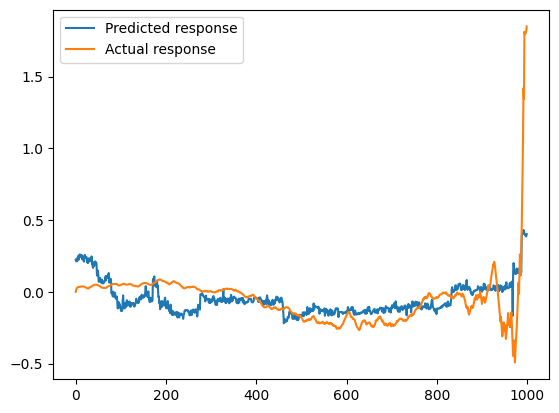

**************************************************
At time 2010-05-06 14:11:13-04:00
Deviation : 48.04374224720697
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:11:15-04:00
Deviation : 48.44909650753337
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:11:16-04:00
Deviation : 48.50454603654201
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:11:17-04:00
Deviation : 48.52320148594288
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:11:18-04:00
Deviation : 48.45462816330431
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:11:19-04:00
Deviation : 48.69795750627497
flash crash: predicted: False, actual : False 
****************************

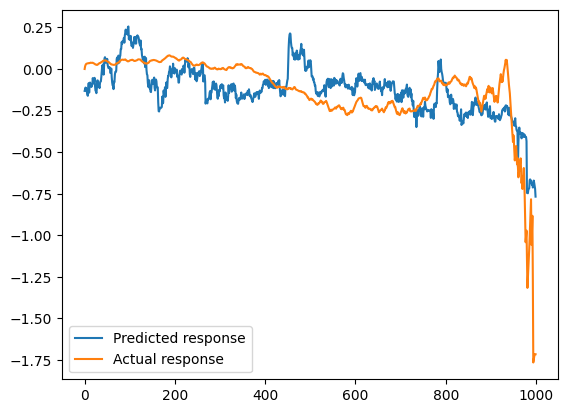

**************************************************
At time 2010-05-06 14:11:23-04:00
Deviation : 49.76801553276947
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:11:24-04:00
Deviation : 50.027566394210126
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:11:26-04:00
Deviation : 50.19131843750351
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:11:27-04:00
Deviation : 50.21906664952803
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:11:28-04:00
Deviation : 50.144634513811816
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:11:29-04:00
Deviation : 50.266939717823064
flash crash: predicted: False, actual : False 
*************************

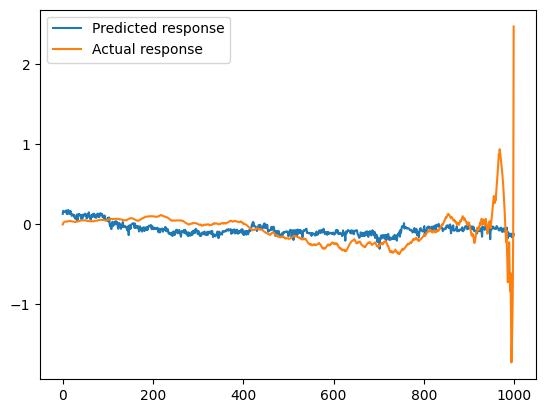

**************************************************
At time 2010-05-06 14:12:05-04:00
Deviation : 53.46810084511368
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:12:06-04:00
Deviation : 53.70110629641069
flash crash: predicted: True, actual : False 
False Flash crash predicted at time 2010-05-06 14:12:06-04:00


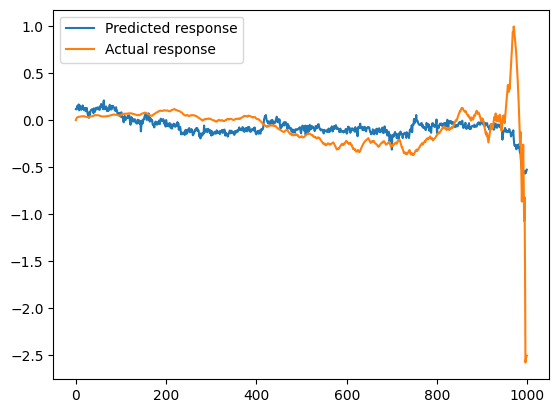

**************************************************
At time 2010-05-06 14:12:07-04:00
Deviation : 54.036271397261785
flash crash: predicted: True, actual : False 
False Flash crash predicted at time 2010-05-06 14:12:07-04:00


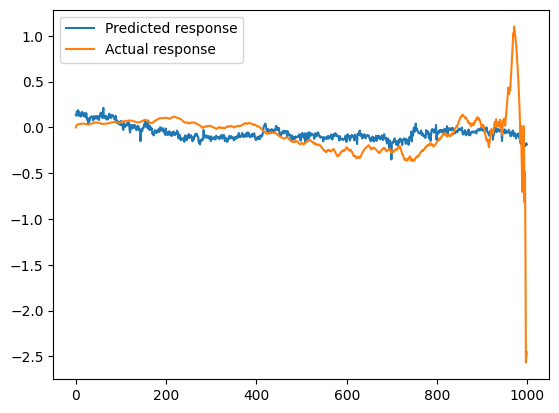

**************************************************
At time 2010-05-06 14:12:08-04:00
Deviation : 54.221067173757845
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:12:09-04:00
Deviation : 54.3135991019204
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:12:10-04:00
Deviation : 54.36833034604733
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:12:11-04:00
Deviation : 54.39877585562931
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:12:12-04:00
Deviation : 54.51132020213187
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:12:13-04:00
Deviation : 54.56624353438617
flash crash: predicted: False, actual : False 
****************************

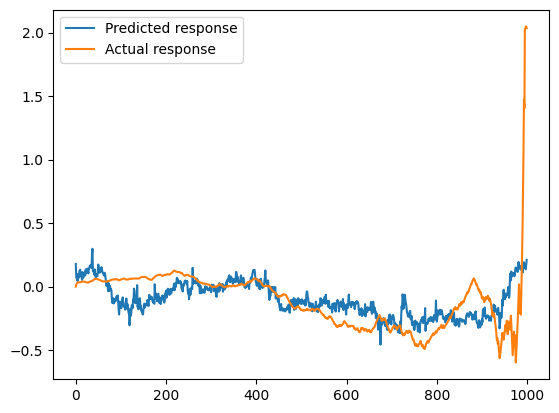

**************************************************
At time 2010-05-06 14:12:40-04:00
Deviation : 56.575246865868
flash crash: predicted: True, actual : False 
False Flash crash predicted at time 2010-05-06 14:12:40-04:00


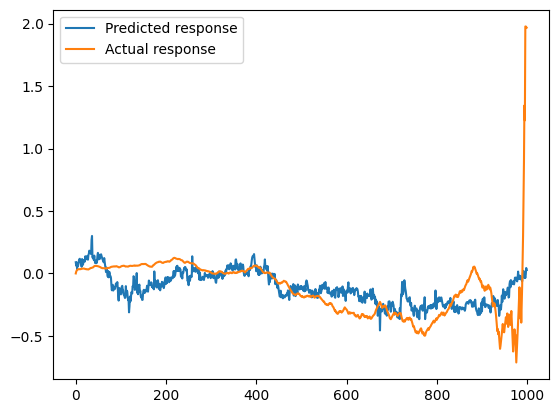

**************************************************
At time 2010-05-06 14:12:41-04:00
Deviation : 56.819935303097836
flash crash: predicted: True, actual : False 
False Flash crash predicted at time 2010-05-06 14:12:41-04:00


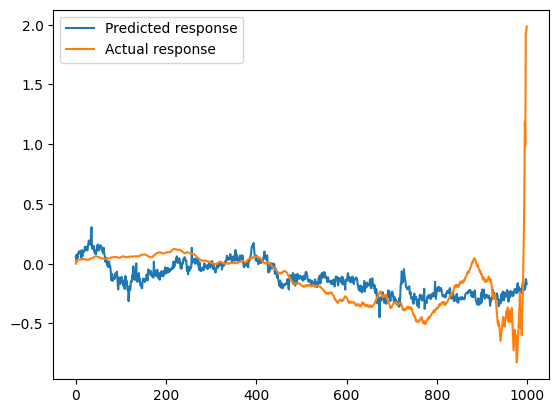

**************************************************
At time 2010-05-06 14:12:42-04:00
Deviation : 56.992744811366556
flash crash: predicted: True, actual : False 
False Flash crash predicted at time 2010-05-06 14:12:42-04:00


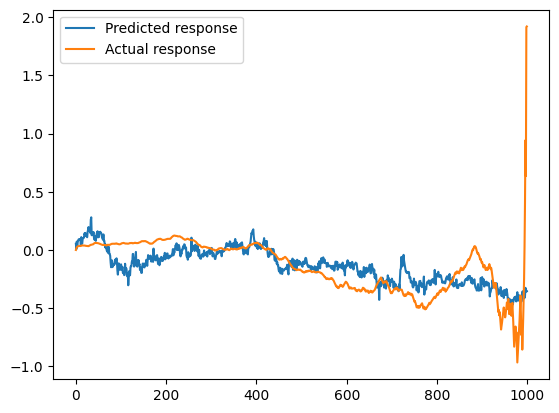

**************************************************
At time 2010-05-06 14:12:43-04:00
Deviation : 57.114839297802185
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:12:48-04:00
Deviation : 57.14917886336073
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:12:49-04:00
Deviation : 57.21914870322681
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:12:50-04:00
Deviation : 57.26400818857498
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:12:51-04:00
Deviation : 57.32075828935605
flash crash: predicted: False, actual : False 
**************************************************
At time 2010-05-06 14:12:53-04:00
Deviation : 57.45955172930662
flash crash: predicted: True, actual : False 
False Flash crash predicted 

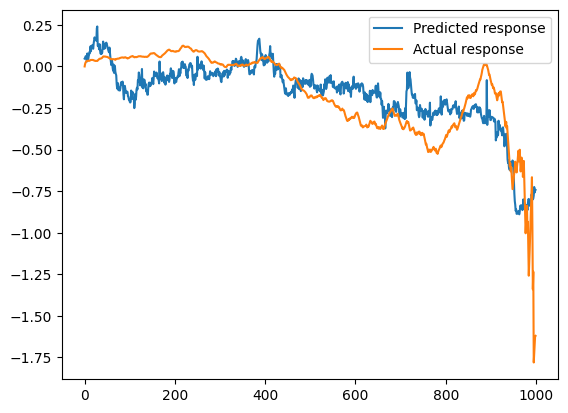

**************************************************
At time 2010-05-06 14:12:55-04:00
Deviation : 57.57800795419406
flash crash: predicted: True, actual : False 
False Flash crash predicted at time 2010-05-06 14:12:55-04:00
**************************************************
At time 2010-05-06 14:12:56-04:00
Deviation : 57.702965334218504
flash crash: predicted: True, actual : False 
False Flash crash predicted at time 2010-05-06 14:12:56-04:00
**************************************************
At time 2010-05-06 14:12:57-04:00
Deviation : 57.84845418607182
flash crash: predicted: True, actual : False 
False Flash crash predicted at time 2010-05-06 14:12:57-04:00
**************************************************
At time 2010-05-06 14:12:58-04:00
Deviation : 57.99238792521584
flash crash: predicted: True, actual : False 
False Flash crash predicted at time 2010-05-06 14:12:58-04:00
**************************************************
At time 2010-05-06 14:12:59-04:00
Deviation : 58.1927909

In [78]:
def compute_deviation(y_pred, y_true):
    distance, _ = fastdtw(y_true, y_pred)
    return distance

# Parameters
k = 1000  # Window size
tau_max = k # should be equal to k
threshold = 70  # Threshold for deviation
df = df[ (df.index>= '2010-05-06') & (df.index<= '2010-05-07') ]
model = LinearRegression()

metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 200
nb_plots = 10
# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    print("At time",df.index[i+1])
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['flash_crash'],inplace=True)
    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    deviation = compute_deviation(y_pred, y_train)
    total_deviation_list.append(deviation)
    
    predicted_flash_crash = False
    if len(deviation_list) >= deviation_nb_threshold:
        window_deviation = np.mean(deviation_list[-deviation_nb_threshold:])
        print("Deviation mean",window_deviation)
        predicted_flash_crash = abs(deviation)  > 1.5 * abs(window_deviation)
    else :
        predicted_flash_crash = deviation > threshold

    metrics = update_metrics(metrics,predicted_flash_crash, df.iloc[i+1].flash_crash)
    y_pred_list.append(predicted_flash_crash )
    end_time = time.time()

    if not bool(df.iloc[i+1].flash_crash) : #not df[i-k:i].flash_crash.sum() :
        deviation_list.append(deviation)

    # Check for flash crash
    # print(f"Time taken: {end_time-start_time}")
    print(f"Deviation : {np.mean(deviation_list[-deviation_nb_threshold:])}")
    print( f"flash crash: predicted: {bool(predicted_flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()
            

In [79]:
metrics

{'TP': 2101, 'TN': 2874, 'FP': 395, 'FN': 59}

In [80]:
f1_score(metrics), accuracy(metrics)

(0.9024914089347079, 0.916375023024498)

#### Model 3) Analytical observations from the response function
- Magnitude of the Response Function
- Volatility of the Response Function
- Stability of the Response Function

At time 2010-05-06 14:10:25-04:00
CV 0.6035345983826254
p_value_t 0.50000000000093  / p_value_u 0.5416006133828623
flash crash: predicted: False, actual : False 
Deviation : 0.5413671458453646
**************************************************
At time 2010-05-06 14:10:26-04:00
CV 0.5118055253908078
p_value_t 0.4999999999999084  / p_value_u 0.20929668039679405
flash crash: predicted: False, actual : False 
Deviation : 0.5785785925962282
**************************************************
At time 2010-05-06 14:10:28-04:00
CV 0.6497637865286285
p_value_t 0.5000000000005369  / p_value_u 0.4227894881924178
flash crash: predicted: False, actual : False 
Deviation : 0.5941845212160756
**************************************************
At time 2010-05-06 14:10:30-04:00
CV 0.5902035540679442
p_value_t 0.49999999999916495  / p_value_u 0.6523002722328174
flash crash: predicted: False, actual : False 
Deviation : 0.5070267089759766
**************************************************
At time 2010-05-

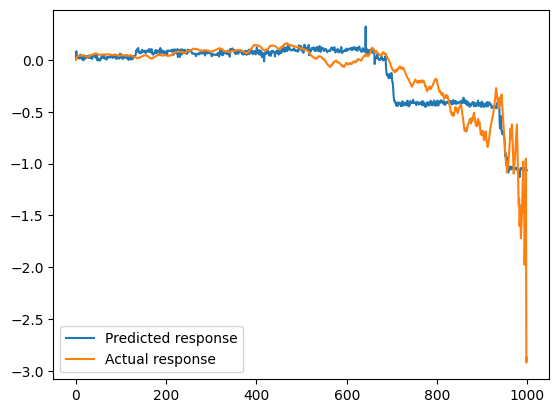

**************************************************
At time 2010-05-06 14:19:42-04:00
CV 0.1167269231470531
p_value_t 0.5000000000002798  / p_value_u 0.7872790326234798
Deviation mean 0.3975206329050877
Deviation std 0.058874568038730084
flash crash: predicted: False, actual : False 
Deviation : 0.23654370341758668
**************************************************
At time 2010-05-06 14:19:43-04:00
CV 0.19049661164074633
p_value_t 0.500000000000963  / p_value_u 0.48955894805713507
Deviation mean 0.39646184016462327
Deviation std 0.05984787143144696
flash crash: predicted: False, actual : False 
Deviation : 0.34785856880584864
**************************************************
At time 2010-05-06 14:19:45-04:00
CV 0.14164076657633995
p_value_t 0.4999999999992874  / p_value_u 0.9000965242077179
Deviation mean 0.39627113480982545
Deviation std 0.05994160031305941
flash crash: predicted: False, actual : False 
Deviation : 0.22079625223641863
**************************************************

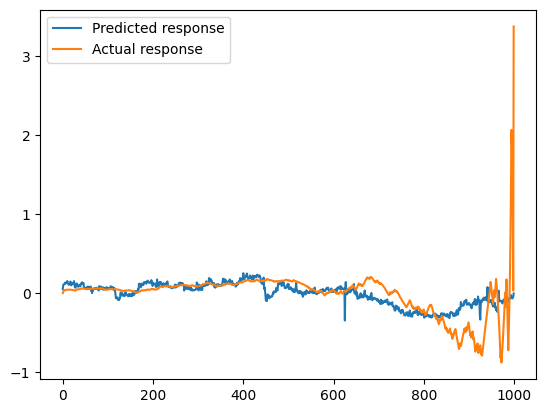

**************************************************
At time 2010-05-06 14:20:04-04:00
CV 0.4000109308301187
p_value_t 0.500000000000095  / p_value_u 0.0017630123763656114
Deviation mean 0.4024442141109389
Deviation std 0.06547802113030449
flash crash: predicted: False, actual : False 
Deviation : 0.5745647123209442
**************************************************
At time 2010-05-06 14:20:05-04:00
CV 0.5545572617313809
p_value_t 0.49999999999919054  / p_value_u 9.693342550145964e-06
Deviation mean 0.40348199583364874
Deviation std 0.06654429422370185
flash crash: predicted: True, actual : False 
Deviation : 0.6522762075302553
False Flash crash predicted at time 2010-05-06 14:20:05-04:00


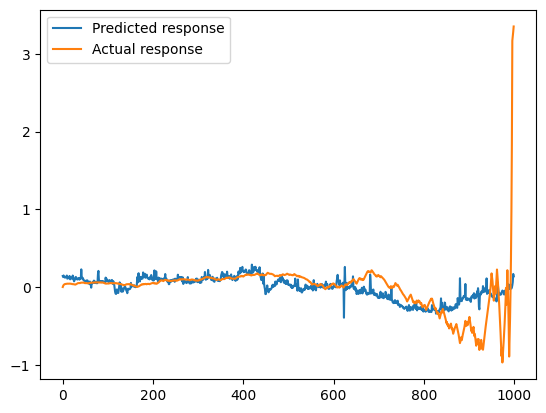

**************************************************
At time 2010-05-06 14:20:08-04:00
CV 0.5138638175878647
p_value_t 0.4999999999995056  / p_value_u 1.4121001493463376e-05
Deviation mean 0.4051160264853344
Deviation std 0.06858962413644462
flash crash: predicted: True, actual : False 
Deviation : 0.6319283785436826
False Flash crash predicted at time 2010-05-06 14:20:08-04:00


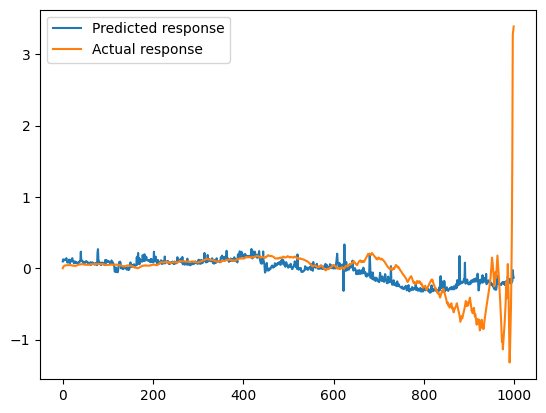

**************************************************
At time 2010-05-06 14:20:09-04:00
CV 0.4421526659055215
p_value_t 0.500000000000076  / p_value_u 0.0002119847778490468
Deviation mean 0.40665570654094935
Deviation std 0.07018888729304747
flash crash: predicted: False, actual : False 
Deviation : 0.5960233367582795
**************************************************
At time 2010-05-06 14:20:10-04:00
CV 0.315859207835647
p_value_t 0.5000000000013365  / p_value_u 0.0270413996870745
Deviation mean 0.4079896516565951
Deviation std 0.07123223024960797
flash crash: predicted: False, actual : False 
Deviation : 0.5261692539957208
**************************************************
At time 2010-05-06 14:20:11-04:00
CV 0.17999219722336027
p_value_t 0.5000000000004341  / p_value_u 0.2674802028629401
Deviation mean 0.4088740297555026
Deviation std 0.07159507302488442
flash crash: predicted: False, actual : False 
Deviation : 0.39812604789583655
**************************************************
At 

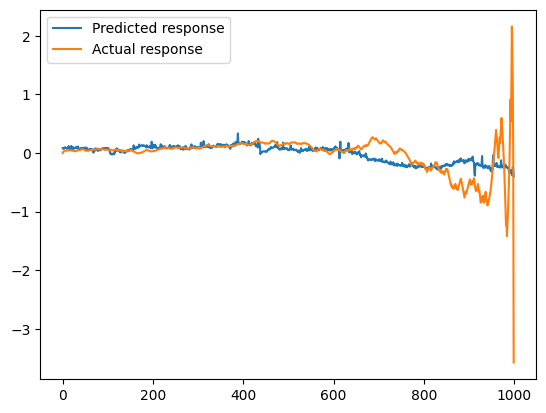

**************************************************
At time 2010-05-06 14:20:19-04:00
CV 0.5796097550411539
p_value_t 0.49999999999911127  / p_value_u 1.0154659162771568e-05
Deviation mean 0.41210124939740644
Deviation std 0.07477409864867053
flash crash: predicted: True, actual : False 
Deviation : 0.6648023388560084
False Flash crash predicted at time 2010-05-06 14:20:19-04:00


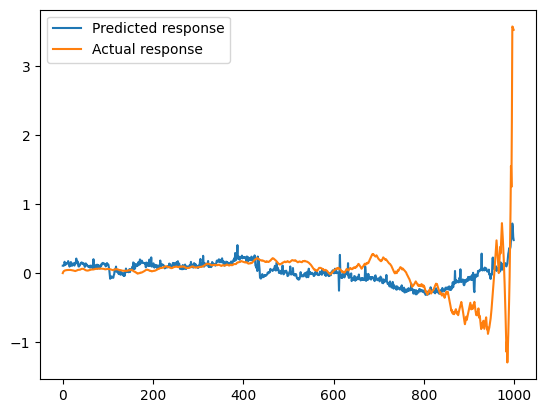

**************************************************
At time 2010-05-06 14:20:20-04:00
CV 0.6144475029712109
p_value_t 0.49999999999934874  / p_value_u 1.223209898639696e-09
Deviation mean 0.41344167704873686
Deviation std 0.0768600994040841
flash crash: predicted: True, actual : False 
Deviation : 0.6822237511799658
False Flash crash predicted at time 2010-05-06 14:20:20-04:00


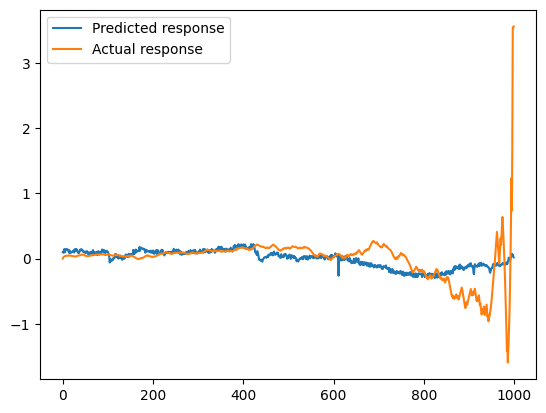

**************************************************
At time 2010-05-06 14:20:23-04:00
CV 0.535480614567338
p_value_t 0.5000000000002339  / p_value_u 5.364373853460762e-06
Deviation mean 0.4148499955421122
Deviation std 0.07915731712889143
flash crash: predicted: False, actual : False 
Deviation : 0.642738966190147
**************************************************
At time 2010-05-06 14:20:24-04:00
CV 0.3509426632258342
p_value_t 0.5000000000004708  / p_value_u 0.00447955619277114
Deviation mean 0.4160384948976498
Deviation std 0.08076913996200374
flash crash: predicted: False, actual : False 
Deviation : 0.5493514425646067
**************************************************
At time 2010-05-06 14:20:25-04:00
CV 0.157688818916584
p_value_t 0.4999999999999419  / p_value_u 0.025976714340078994
Deviation mean 0.4167718524781664
Deviation std 0.08130858263544981
flash crash: predicted: False, actual : False 
Deviation : 0.4473502308732868
**************************************************
At t

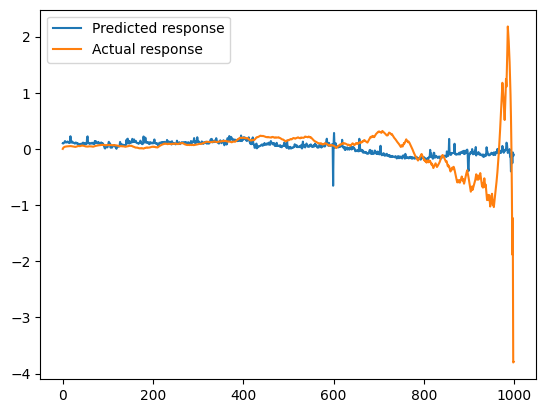

**************************************************
At time 2010-05-06 14:20:36-04:00
CV 0.6626402367223703
p_value_t 0.4999999999993905  / p_value_u 2.671743937750648e-08
Deviation mean 0.4244137397845947
Deviation std 0.08860784726696824
flash crash: predicted: True, actual : False 
Deviation : 0.7063201116819777
False Flash crash predicted at time 2010-05-06 14:20:36-04:00


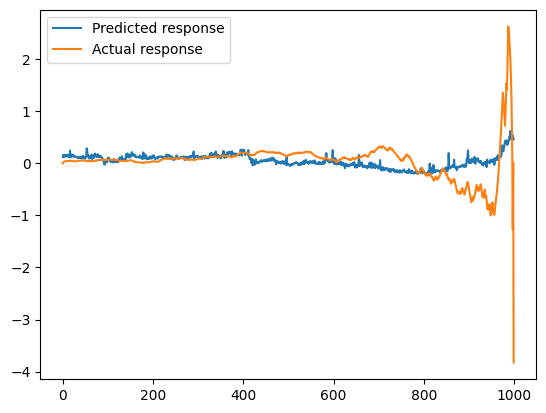

**************************************************
At time 2010-05-06 14:20:37-04:00
CV 0.4568654853592528
p_value_t 0.499999999998107  / p_value_u 0.003797960983022276
Deviation mean 0.4259899092012679
Deviation std 0.09077812888986554
flash crash: predicted: False, actual : False 
Deviation : 0.6024832524343441
**************************************************
At time 2010-05-06 14:20:38-04:00
CV 0.5759283850605136
p_value_t 0.4999999999984664  / p_value_u 3.828109572567386e-06
Deviation mean 0.4270948206038604
Deviation std 0.09157128932619366
flash crash: predicted: False, actual : False 
Deviation : 0.6629632355032471
**************************************************
At time 2010-05-06 14:20:39-04:00
CV 0.41541257010561444
p_value_t 0.499999999999137  / p_value_u 0.03326816476195831
Deviation mean 0.4284691506312606
Deviation std 0.09302675814633939
flash crash: predicted: False, actual : False 
Deviation : 0.5743892438625333
**************************************************
At

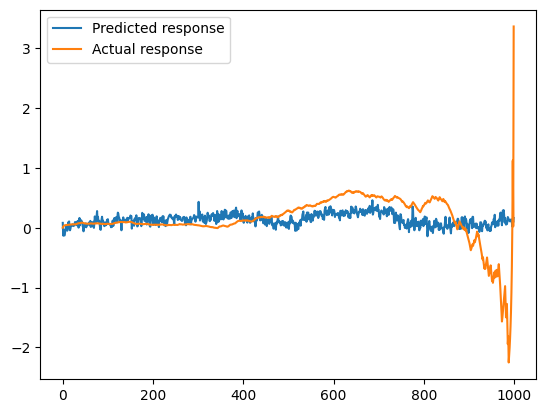

**************************************************
At time 2010-05-06 14:26:53-04:00
CV 0.7573716447645371
p_value_t 0.5000000000000034  / p_value_u 2.2175884378160628e-07
Deviation mean 0.3665186710564221
Deviation std 0.10258804366031178
flash crash: predicted: True, actual : False 
Deviation : 0.7536857669425567
False Flash crash predicted at time 2010-05-06 14:26:53-04:00
**************************************************
At time 2010-05-06 14:26:54-04:00
CV 0.7686934221287236
p_value_t 0.49999999999786604  / p_value_u 0.0009892841373496054
Deviation mean 0.36823124948489094
Deviation std 0.1061173729212143
flash crash: predicted: True, actual : False 
Deviation : 0.7590993900305578
False Flash crash predicted at time 2010-05-06 14:26:54-04:00
**************************************************
At time 2010-05-06 14:26:56-04:00
CV 0.7631121502307826
p_value_t 0.5000000000007861  / p_value_u 1.6964276120038452e-11
Deviation mean 0.3699750221284763
Deviation std 0.10960327471216104
fl

KeyboardInterrupt: 

In [66]:
def compute_deviation(y_pred, y_true , weight_ttest=0.5,  weight_stability=0.5 ):
    # Response magnitude
    _, p_value_t = ttest_ind(y_pred, y_true,alternative='less',equal_var=False)
    _, p_value_u = ranksums(y_pred, y_true,alternative='less')

    # Calculate the coefficient of variation (CV)
    cv_true = abs(np.std(y_true) / np.mean(y_true))
    cv_pred = abs(np.std(y_pred) / np.mean(y_pred))
    if cv_true>cv_pred:
        deviation_stability = ((cv_true-cv_pred)/ cv_true)
    else:
        deviation_stability = ((cv_pred-cv_true)/ cv_pred)
    # print("CV",deviation_stability)
    # print("p_value_t",p_value_t," / p_value_u",p_value_u)
    # overall_deviation = ((p_value_t<=0.05) or (p_value_u<=0.05)) * weight_ttest + deviation_stability * weight_stability
    overall_deviation = ((2-p_value_t-p_value_u)/2) * weight_ttest + deviation_stability * weight_stability
    # overall_deviation =  
    return overall_deviation



# Parameters
k = 1000  # Window size
tau_max = k # should be equal to k
threshold = 0.9  # Threshold for deviation
# Initialize model
df = df[ (df.index>= '2010-05-06') & (df.index<= '2010-05-07') ]
model = LinearRegression()
metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 200
nb_plots = 10
# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    print("At time",df.index[i+1])
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['flash_crash'],inplace=True)
    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    deviation = compute_deviation(y_pred, y_train)
    total_deviation_list.append(deviation)
    
    predicted_flash_crash = False
    if len(deviation_list) >= deviation_nb_threshold:
        window_deviation = np.mean(deviation_list[-deviation_nb_threshold:])
        window_std = np.std(deviation_list[-deviation_nb_threshold:])
        print("Deviation mean",window_deviation)
        print("Deviation std",window_std)
        predicted_flash_crash = abs(deviation - window_deviation)  > abs(3*window_std)
        # predicted_flash_crash = abs(deviation)  > 1.5 * abs(window_deviation)
    else :
        predicted_flash_crash = deviation > threshold

    metrics = update_metrics(metrics,predicted_flash_crash, df.iloc[i+1].flash_crash)
    y_pred_list.append(predicted_flash_crash )
    end_time = time.time()

    if not bool(df.iloc[i+1].flash_crash) : #not df[i-k:i].flash_crash.sum() :
        deviation_list.append(deviation)

    # Check for flash crash
    # print(f"Time taken: {end_time-start_time}")
    print( f"flash crash: predicted: {bool(predicted_flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    print(f"Deviation : {deviation}")
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()
    print('*'*50)
            

In [59]:
metrics

{'TP': 1058, 'TN': 2965, 'FP': 304, 'FN': 1102}

In [60]:
f1_score(metrics), accuracy(metrics)

(0.6007950028392959, 0.7410204457542826)